In [1]:
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import math
from collections import Counter

# post-comment similarity and inter-comment similarity
WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
     intersection = set(vec1.keys()) & set(vec2.keys())
     numerator = sum([vec1[x] * vec2[x] for x in intersection])

     sum1 = sum([vec1[x]**2 for x in vec1.keys()])
     sum2 = sum([vec2[x]**2 for x in vec2.keys()])
     denominator = math.sqrt(sum1) * math.sqrt(sum2)

     if not denominator:
        return 0.0
     else:
        return float(numerator) / denominator


def text_to_vector(text):
     words = WORD.findall(text)
     return Counter(words)


text1 = 'This is a foo bar sentence .'
text2 = 'This sentence is similar to a foo bar sentence .'

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

cosine = get_cosine(vector1, vector2)

print('Cosine:', cosine)

Cosine: 0.8616404368553293


In [2]:
file_names = ('ranjan-youtube-comments.csv', 'music-youtube-comments.csv', 
              'sangeethe-youtube-comments.csv', 'ratta-youtube-comments.csv', 'vlog-youtube-comments.csv')
df = pd.DataFrame()

# post-comment similarity and inter-comment similarity
for file in file_names: #iterating over the files
    df_temp = pd.read_csv(file)
    df_temp['p_jc_similarity'] = 0.0 #post comment similarity in jaccard
    df_temp['jc_similarity'] = 0.0 #average inter-comment similarity in jaccard
    df_temp['p_cs_similarity'] = 0.0 #post comment similarity in cosine
    df_temp['cs_similarity'] = 0.0 #average inter-comment similarity in cosine
    des_tkns = set(nltk.tokenize.word_tokenize(str(df_temp['description'][0])))
    #creating vector for description to calculate cosine similarity
    vector1 = text_to_vector(str(df_temp['description'][0]))

    for index, row in df_temp.iterrows():
        #calculating post-comment similarity in jaccard
        tkns = set(nltk.tokenize.word_tokenize(str(row['text_display'])))
        intersection = len(des_tkns.intersection(tkns))
        union = len(des_tkns) + len(tkns) - intersection
        df_temp.at[index, 'p_jc_similarity'] = intersection / union
        
        #calculating post comment similarity in cosine similarity
        vector2 = text_to_vector(str(row['text_display']))
        df_temp.at[index, 'p_cs_similarity'] = get_cosine(vector1, vector2)
        
        total = total2 = 0
        for i, snt in df_temp.iterrows():
            if i == index:
                continue
            tkns2 = set(nltk.tokenize.word_tokenize(str(snt['text_display'])))
            intersection = len(tkns.intersection(tkns2))
            union = len(tkns) + len(tkns2) - intersection
            total = total + (intersection / union) #adding similarities
            vector2 = text_to_vector(str(snt['text_display']))
            total2 = total2 + get_cosine(vector1, vector2) #adding similarities
        #getting average inter comment similarities
        df_temp.at[index, 'cs_similarity'] = total2 / (len(df_temp) - 1)
        df_temp.at[index, 'jc_similarity'] = total / (len(df_temp) - 1)
    df = df.append(df_temp)

In [3]:
#the interval between post and comment
t1 = pd.to_datetime(df['publishedAt'])
t2 = pd.to_datetime(df['videoUploadedAt'])
df['interval'] = (t1 - t2).dt.total_seconds() # seconds

In [4]:
#number of words in the comment
df['no_words'] = df['text_original'].str.split().apply(len)

In [5]:
#comment length
df['comment_length'] = df['text_original'].str.len()

In [6]:
#stop words ratio
stopwords = pd.read_csv('stopwords.txt', header=None)[0].to_numpy()

df['stop_w_ratio'] = 0.0

for index, row in df.iterrows():
    count = 0
    tkns = nltk.tokenize.word_tokenize(str(row['text_original']))
    for tk in tkns:
        if tk in stopwords:
            count = count + 1
    df.at[index, 'stop_w_ratio'] = count / len(tkns)

In [7]:
#link, email, phone and black words
df['has_link'] = 0
df['has_subscribe'] = 0
df['has_email'] = 0
df['has_phone'] = 0

word_list = ['subscribe', 'subcribe', 'subcrib', 'සබ්ස්']

for index, row in df.iterrows():
    if any(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(row['text_original']))):
        df.at[index, 'has_link'] = 1
    
    if any(re.findall(r'|'.join(word_list), str(row['text_original']), re.IGNORECASE)):
        df.at[index, 'has_subscribe'] = 1
        
    if any(re.findall(r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', str(row['text_original']))):
        df.at[index, 'has_email'] = 1
        
    if any(re.findall(r'[0-9]{7,}', str(row['text_original']))):
        df.at[index, 'has_phone'] = 1

In [8]:
#no of sentences
df['no_sentences'] = df['text_original'].str.replace('?', '.').str.replace('!', '.').str.split('.').apply(len)

In [9]:
#word duplication ratio
df['word_dup_ratio'] = 0.0

for index, row in df.iterrows():
    count = dict()
    words = row['text_original'].split()
    for word in words:
        if word not in count:
            count[word] = 0
        count[word] += 1
    
    duplicates = 0
    for item in count:
        if count[item] > 1:
            duplicates += 1
    df.at[index, 'word_dup_ratio'] = duplicates / len(words)

In [10]:
# alpha numeric and non alpha numeric char ratio
alphanum = pd.read_csv('sin_letters.txt', header=None)[0].to_numpy()

df['al_num_ratio'] = 0.0
df['non_al_num_ratio'] = 0.0

for index, row in df.iterrows():
    count = 0
    comment = str(row['text_original'])
    com_len = len(comment)
    for ch in comment:
        if ch in alphanum:
            count = count + 1
    df.at[index, 'al_num_ratio'] = count / com_len
    df.at[index, 'non_al_num_ratio'] = (com_len - count) / com_len

In [11]:
# negative word count and ratio
negativewords = pd.read_csv('negative-words_si.txt', header=None)[0].to_numpy()

df['neg_w_count'] = 0
df['neg_w_ratio'] = 0.0

for index, row in df.iterrows():
    count = 0
    tkns = nltk.tokenize.word_tokenize(str(row['text_original']))
    for tk in tkns:
        if tk in negativewords:
            count = count + 1
    df.at[index, 'neg_w_count'] = count
    df.at[index, 'neg_w_ratio'] = count / len(tkns)

In [12]:
# positive word count and ratio
positivewords = pd.read_csv('positive-words_si.txt', header=None)[0].to_numpy()

df['pos_w_count'] = 0
df['pos_w_ratio'] = 0.0

for index, row in df.iterrows():
    count = 0
    tkns = nltk.tokenize.word_tokenize(str(row['text_original']))
    for tk in tkns:
        if tk in positivewords:
            count = count + 1
    df.at[index, 'pos_w_count'] = count
    df.at[index, 'pos_w_ratio'] = count / len(tkns)

In [13]:

user_details = df[df.is_spam == 1][['authorChannelId', 'subscriberCount', 'videoCount', 'channelViewCount']]
user_details

,authorChannelId,subscriberCount,videoCount,channelViewCount
1,UCJh8tRprawVFIk7oHbIUNgw,19,4,150
4,UCVFCjr3prM5nWNZRixyPIqg,0,12,242511
6,UClxuGJD4y3fQ6ew21mj0ApA,16,13,336
7,UCMVZFl51gTtuUmO6iav33ew,0,0,0
8,UCX1MlmfPHjcZahA_2IbMH0Q,11,2,428
13,UCdOyi1XOX1iFwvOgJzDAnAA,113,12,848
14,UCjU7UzFjtppLWQNl6s9F8lw,1,8,107
15,UCF7825i1T5FQmCYDPQoKqiw,490,118,47848
16,UC3n9NwEr7MGksjbzEX2-Gww,2550,30,542478
17,UCuZE2E3l8LDEEJhMQJOw0xA,1,4,119


In [14]:
X = df[['has_link', 'has_subscribe', 'has_email', 'has_phone', 'p_jc_similarity', 'jc_similarity', 'p_cs_similarity', 'cs_similarity', 'likeCount', 'interval', 'no_words', 'comment_length', 'stop_w_ratio', 'no_sentences', 'word_dup_ratio', 'al_num_ratio', 'non_al_num_ratio', 'neg_w_ratio', 'pos_w_ratio', 'videoCount', 'channelViewCount']]
y = df['is_spam']
X.head()

,has_link,has_subscribe,has_email,has_phone,p_jc_similarity,jc_similarity,p_cs_similarity,cs_similarity,likeCount,interval,...,comment_length,stop_w_ratio,no_sentences,word_dup_ratio,al_num_ratio,non_al_num_ratio,neg_w_ratio,pos_w_ratio,videoCount,channelViewCount
0,1,0,0,0,0.041667,0.006307,0.467379,0.256023,189,19459.0,...,53,0.218750,1,0.040000,0.708333,0.291667,0.000000,0.03125,1,37
1,1,0,0,0,0.000000,0.180282,0.000000,0.260272,0,339711.0,...,64,0.150000,3,0.000000,0.612903,0.387097,0.000000,0.00000,4,150
2,1,0,0,0,0.035714,0.005627,0.277350,0.257751,0,338050.0,...,61,0.200000,5,0.000000,0.765957,0.234043,0.000000,0.00000,7,174
3,1,1,0,0,0.000000,0.007030,0.107990,0.259290,0,334046.0,...,49,0.173913,1,0.102564,0.785714,0.214286,0.065217,0.00000,41,712
4,1,1,0,0,0.021277,0.092885,0.483104,0.255880,0,333175.0,...,160,0.042553,4,0.000000,0.384615,0.615385,0.000000,0.00000,12,242511


In [15]:
df_corr = df[['is_spam', 'has_link', 'has_subscribe', 'has_email', 'has_phone', 'p_jc_similarity', 'jc_similarity', 'p_cs_similarity', 'cs_similarity', 'likeCount', 'interval', 'no_words', 'comment_length', 'stop_w_ratio', 'no_sentences', 'word_dup_ratio', 'al_num_ratio', 'non_al_num_ratio', 'neg_w_count', 'neg_w_ratio', 'pos_w_count', 'pos_w_ratio', 'subscriberCount', 'videoCount', 'channelViewCount']]
df_corr.corr()

,is_spam,has_link,has_subscribe,has_email,has_phone,p_jc_similarity,jc_similarity,p_cs_similarity,cs_similarity,likeCount,...,word_dup_ratio,al_num_ratio,non_al_num_ratio,neg_w_count,neg_w_ratio,pos_w_count,pos_w_ratio,subscriberCount,videoCount,channelViewCount
is_spam,1.000000,0.323718,0.097967,NaN,0.074069,-0.023135,0.731297,-0.209660,-0.048863,-0.160098,...,0.024971,-0.086314,0.086314,-0.012982,-0.021897,0.006806,0.013386,-0.021328,0.147092,-0.029294
has_link,0.323718,1.000000,0.091227,NaN,0.122169,0.011448,0.309513,-0.104391,0.099936,-0.171904,...,0.003955,-0.132208,0.132208,-0.020401,-0.114660,-0.046491,0.078758,-0.073307,0.065601,-0.069501
has_subscribe,0.097967,0.091227,1.000000,NaN,-0.118798,0.008496,0.033211,0.013502,0.069214,-0.091874,...,0.223725,0.059959,-0.059959,0.232296,0.149071,0.079425,0.101739,-0.036155,-0.002104,-0.029999
has_email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_phone,0.074069,0.122169,-0.118798,NaN,1.000000,-0.044593,0.042282,-0.031246,0.024640,-0.034283,...,-0.071890,0.077499,-0.077499,-0.043847,-0.045395,-0.057718,-0.050105,-0.010783,-0.018320,-0.009846
p_jc_similarity,-0.023135,0.011448,0.008496,NaN,-0.044593,1.000000,-0.056529,0.198684,0.121959,0.015054,...,0.059067,-0.002611,0.002611,-0.035294,-0.037470,-0.016283,-0.008686,-0.015421,-0.035984,-0.013934
jc_similarity,0.731297,0.309513,0.033211,NaN,0.042282,-0.056529,1.000000,-0.327288,0.059873,-0.142291,...,-0.049660,-0.043335,0.043335,-0.043630,-0.027987,-0.015516,0.034984,-0.033270,0.100709,-0.034068
p_cs_similarity,-0.209660,-0.104391,0.013502,NaN,-0.031246,0.198684,-0.327288,1.000000,0.243937,0.033832,...,0.077861,0.123599,-0.123599,0.026594,0.021859,-0.018224,-0.021576,-0.002196,-0.100177,-0.001699
cs_similarity,-0.048863,0.099936,0.069214,NaN,0.024640,0.121959,0.059873,0.243937,1.000000,-0.131515,...,0.005367,0.006682,-0.006682,0.026479,0.026855,-0.015763,0.009619,-0.043001,-0.063314,-0.039733
likeCount,-0.160098,-0.171904,-0.091874,NaN,-0.034283,0.015054,-0.142291,0.033832,-0.131515,1.000000,...,-0.016054,0.038867,-0.038867,-0.049210,-0.044170,0.077379,0.004951,-0.014347,-0.039910,-0.013903


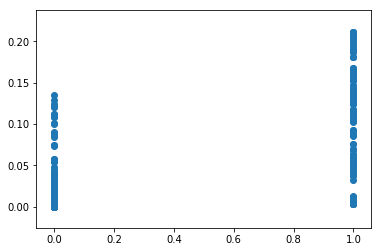

In [16]:
plt.scatter(df['is_spam'], df['jc_similarity'])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gnb = MultinomialNB()
gnb.fit(x_train, y_train)
pred = gnb.predict(x_test)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [18]:
np.array(y_test)

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], dtype=int64)

In [19]:
gnb.score(x_test, y_test)

0.25252525252525254

In [20]:
cnf_matrix = confusion_matrix(np.array(y_test), pred)
cnf_matrix

array([[ 1, 70],
       [ 4, 24]], dtype=int64)

In [21]:
tn, fp, fn, tp = confusion_matrix(np.array(y_test), pred).ravel()
print(tn)
print(fp)
print(fn)
print(tp)

1
70
4
24


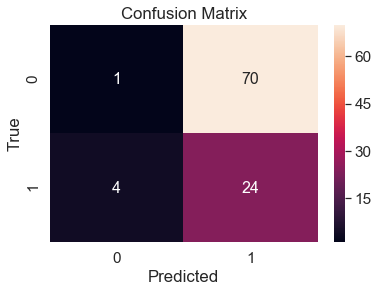

In [22]:
df_cm = pd.DataFrame(cnf_matrix, range(2), range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
estimator = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
selector.support_

array([False, False, False, False, False,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True])

In [24]:
# Reducing features
X = df[['has_link', 'jc_similarity', 'interval']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gnb = MultinomialNB()
gnb.fit(x_train, y_train)
pred = gnb.predict(x_test)
gnb.score(x_test, y_test)

0.6767676767676768

In [25]:
model = SVC(gamma='auto', kernel='linear')
model.fit(x_train, y_train)
model.predict(x_test)
model.score(x_test, y_test)

0.7070707070707071

In [26]:
# Create the model with 100 trees
tree = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
tree.fit(x_train, y_train)
rf_predictions =    tree.predict(x_test)
tree.score(x_test, y_test)

0.9191919191919192

In [27]:
nb = GaussianNB()
nb.fit(x_train, y_train)
nb_pred = nb.predict(x_test)
nb.score(x_test, y_test)

0.7373737373737373

In [28]:
lr = LogisticRegression(solver='liblinear').fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr.score(x_test, y_test)

0.6767676767676768

In [29]:
knn = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn.score(x_test, y_test)

0.6565656565656566

In [30]:
# Reducing features
X = df[['has_link', 'has_subscribe', 'has_email', 'has_phone', 'p_jc_similarity', 'jc_similarity', 'p_cs_similarity', 'cs_similarity', 'likeCount', 'interval', 'no_words', 'comment_length', 'stop_w_ratio', 'no_sentences', 'word_dup_ratio', 'al_num_ratio', 'non_al_num_ratio', 'neg_w_ratio', 'pos_w_ratio', 'videoCount', 'channelViewCount']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tree = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
tree.fit(x_train, y_train)
rf_predictions = tree.predict(x_test)
tree.score(x_test, y_test)

0.9595959595959596

In [31]:
knn = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn.score(x_test, y_test)

0.7272727272727273

In [32]:
lr = LogisticRegression(solver='liblinear').fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr.score(x_test, y_test)

0.898989898989899

In [33]:
nb = GaussianNB()
nb.fit(x_train, y_train)
nb_pred = nb.predict(x_test)
nb.score(x_test, y_test)

0.3333333333333333

In [34]:
# model = SVC(gamma='auto', kernel='linear')
# model.fit(x_train, y_train)
# model.predict(x_test)
# model.score(x_test, y_test)